# Stochastic Pertubations

In [1]:
#JAX
import jax.numpy as jnp
import jax.random as jran
from jax import vmap

#Scipy
from scipy.ndimage.filters import gaussian_filter

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


#JaxMan
from JaxMan.manifold.riemannian.RiemannianManifold import RiemannianManifold
from JaxMan.manifold.lorentzian.LorentzianManifold import LorentzianManifold

/tmp/ipykernel_36852/3023412132.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
mua_fun = lambda t,x: jnp.exp(-((x[0])**2-t**2))
mub_fun = lambda t,x: jnp.exp(-((x[1])**2-t**2))
mutheta_fun = lambda t,x: jnp.sum(x)+t

sigmaa_fun = lambda t,x: 1-jnp.exp(-(x[0]+t)**4)
sigmab_fun = lambda t,x: 1-jnp.exp(-(x[1]+t)**4)
sigmatheta_fun = lambda t,x: 1-jnp.exp(-(x[0]+t)**4)

In [4]:
N_sim = 100

In [5]:
key = jran.PRNGKey(2712)
eps = jran.normal(key, shape=(N_sim,3))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Position-Dependent Metric

### Defining the Metric

In [6]:
mua = lambda x: mua_fun(0,x)
mub = lambda x: mub_fun(0,x)
mutheta = lambda x: mutheta_fun(0,x)

sigmaa = lambda x: sigmaa_fun(0,x)
sigmab = lambda x: sigmab_fun(0,x)
sigmatheta = lambda x: sigmatheta_fun(0,x)

def G(x, eps):
    
    theta = mutheta(x)+eps[0]*sigmatheta(x)
    a2 = (mua(x)+eps[1]*sigmaa(x))**2
    b2 = (mub(x)+eps[2]*sigmab(x))**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
RM = RiemannianManifold(G=G, dim=2, GeodesicMethod="ODE", ODEMethod = "euler", maxiter=10000, tol=1e-6)

### Indicatrix

In [7]:
def indicatrix(x, eps, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    theta = mutheta(x)+eps[0]*sigmatheta(x)
    a = (mua(x)+eps[1]*sigmaa(x))
    b = (mub(x)+eps[2]*sigmab(x))
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [8]:
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [9]:
q1, q2 = vmap(lambda z: vmap(lambda x: vmap(lambda y: indicatrix(y, z))(x))(X))(eps)

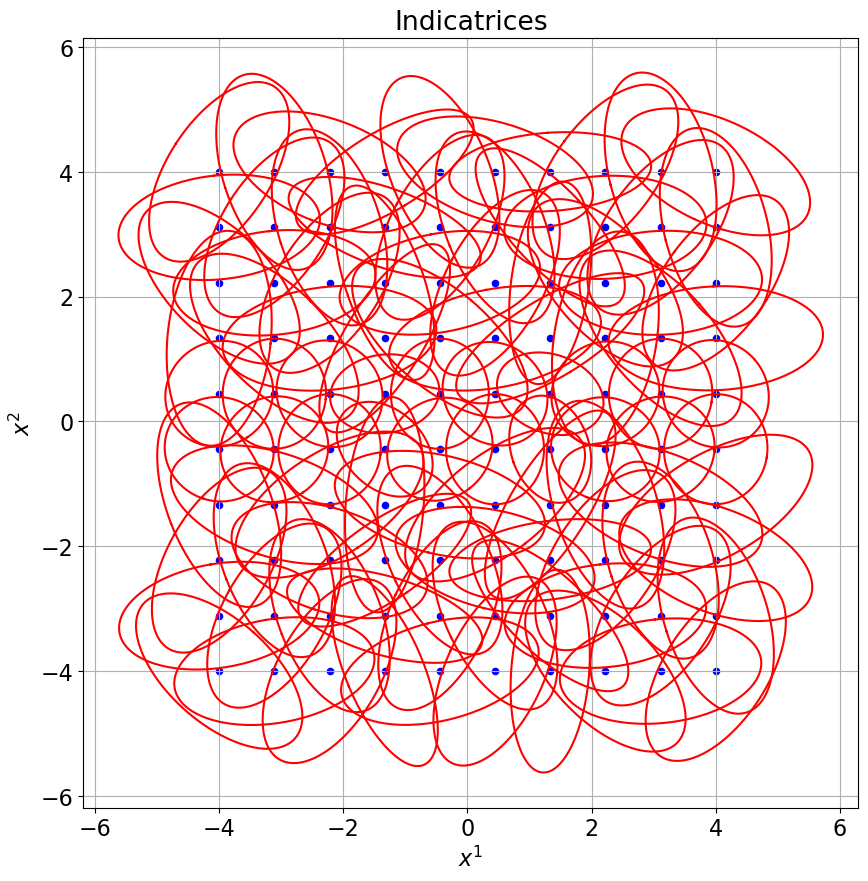

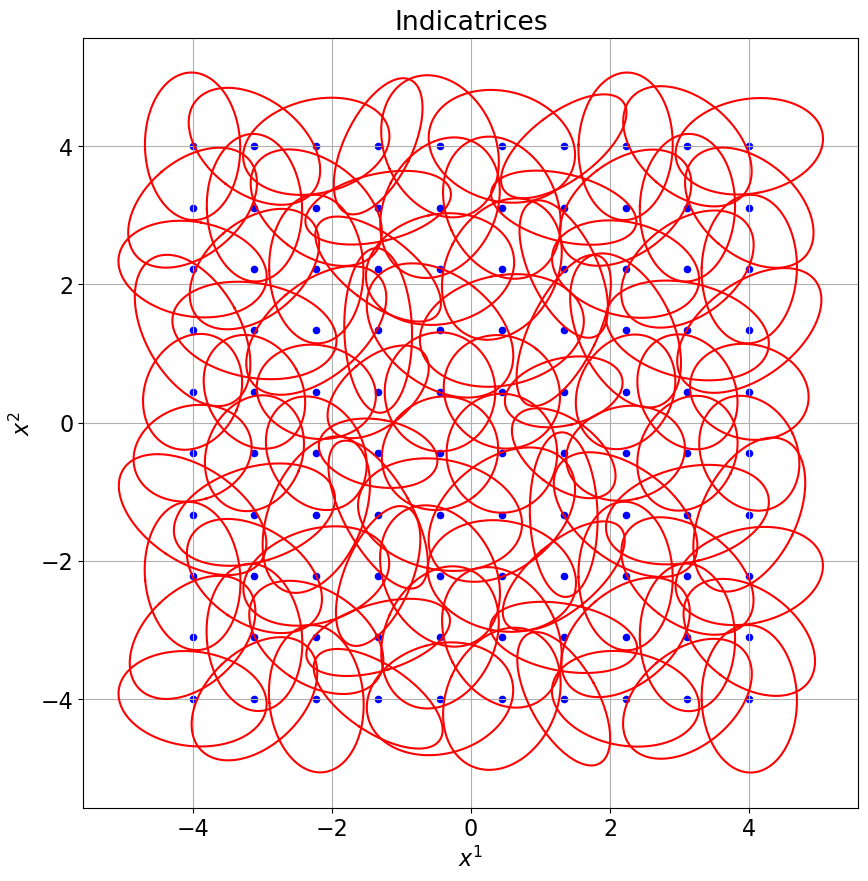

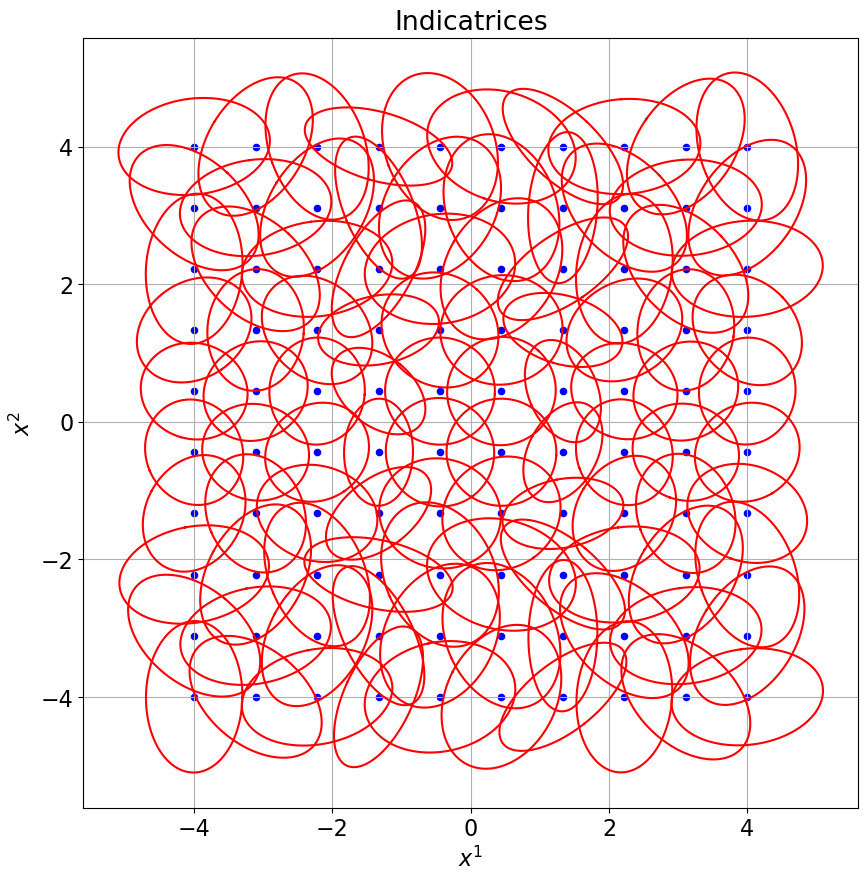

In [10]:
for k in range(3):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    for i in range(N_grid):
        for j in range(N_grid):
            ax.plot(q1[k,i,j,:], q2[k,i,j,:], color='red')
            ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
            
    ax.set_xlabel("$x^{1}$")
    ax.set_ylabel("$x^{2}$")
    ax.set_title("Indicatrices")
    ax.grid()
    fig.savefig("Figures/Riemannian/stochastic/p_indicatrix"+str(k+1)+".pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [11]:
def ivp_fun(eps):
    
    RM = RiemannianManifold(G=lambda x: G(x,eps), dim=2, GeodesicMethod="ODE", ODEMethod = "rk4", 
                            maxiter=100, tol=1e-3, dt=1e-2)
    
    t, gamma, dgamma = vmap(lambda v: RM.IVPGeodesic(x0, v))(v)
    
    return t, gamma, dgamma
    

N_spray = 50
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

t, gamma, dgamma = vmap(ivp_fun)(eps)

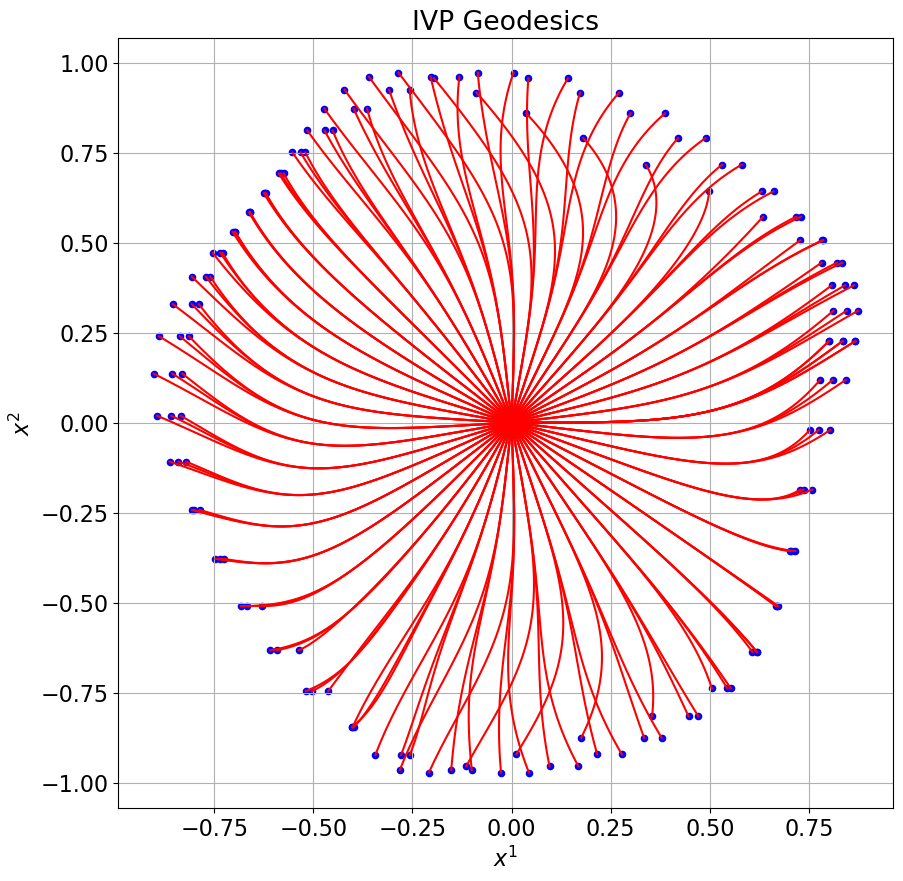

In [12]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k in range(3):
    ax.plot(gamma[k,:,:,0].T, gamma[0,:,:,1].T, color='red')
    ax.scatter(gamma[k,:,-1,0], gamma[0,:,-1,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.grid()
fig.savefig("Figures/Riemannian/stochastic/p_ivp.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [ ]:
def ivp_fun(eps):
    
    RM = RiemannianManifold(G=lambda x: G(x,eps), dim=2, GeodesicMethod="ODE", ODEMethod = "rk4", 
                            maxiter=1000, tol=1e-3, dt=1e-2)
    
    t, gamma, dgamma = vmap(lambda v: RM.BVPGeodesic(x0, v))(v)
    
    return t, gamma, dgamma
    

N_spray = 50
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

t, gamma, dgamma = vmap(ivp_fun)(eps)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for k in range(3):
    ax.plot(gamma[k,:,:,0].T, gamma[0,:,:,1].T, color='red')
    ax.scatter(gamma[k,:,-1,0], gamma[0,:,-1,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("BVP Geodesics")
ax.grid()
fig.savefig("Figures/Riemannian/p_bvp.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [12]:
def sec_fun()

N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda x: vmap(lambda y: RM.SectionalCurvature(y, e1, e2))(x))(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


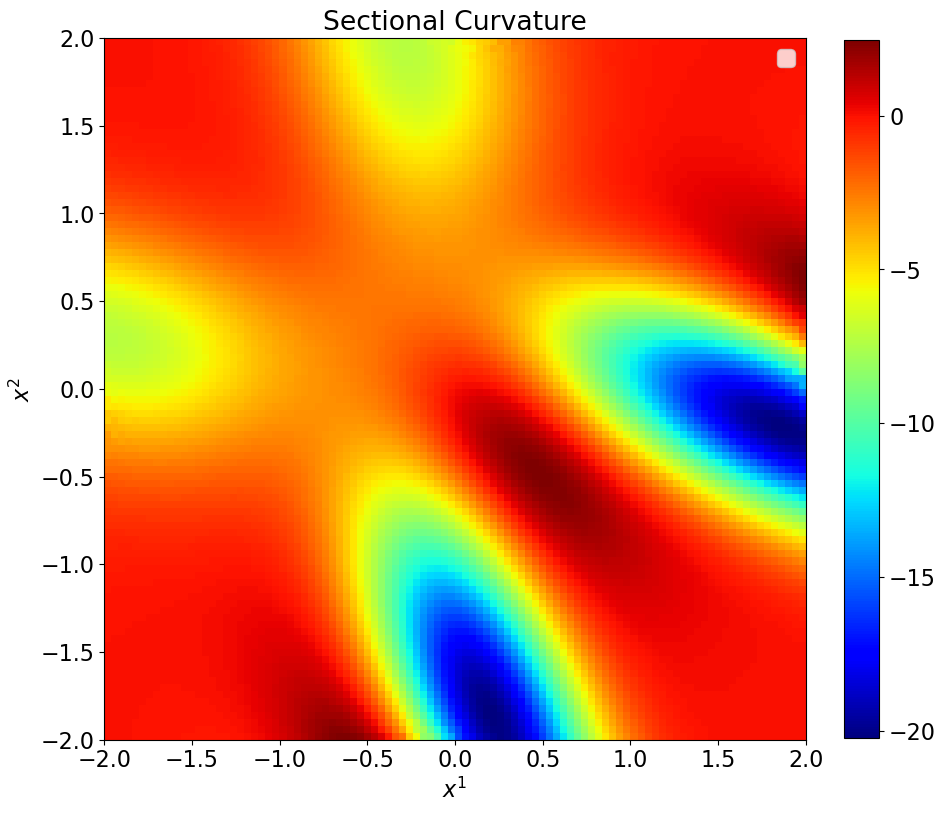

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

fig.savefig("Figures/Riemannian/p_curvature.pdf", format="pdf", bbox_inches="tight")

## Time-Dependent Metric

### Defining the Metric

In [14]:
a_fun = lambda t: jnp.exp(-(t**2))
b_fun = lambda t: jnp.exp(-(t**2))
theta_fun = lambda t: t

def G(t,x):
    
    theta = theta_fun(t)
    a2 = a_fun(t)**2
    b2 = b_fun(t)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
LM = LorentzianManifold(h=G, dim=2, GeodesicMethod="ODE")

### Indicatrix

In [15]:
def indicatrix(t, x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(t)
    b = b_fun(t)
    theta = theta_fun(t)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [16]:
t = jnp.array([0.1, 0.5, 1.0])
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [17]:
q1, q2 = vmap(lambda t: vmap(lambda x: vmap(lambda y: indicatrix(t,y))(x))(X))(t)

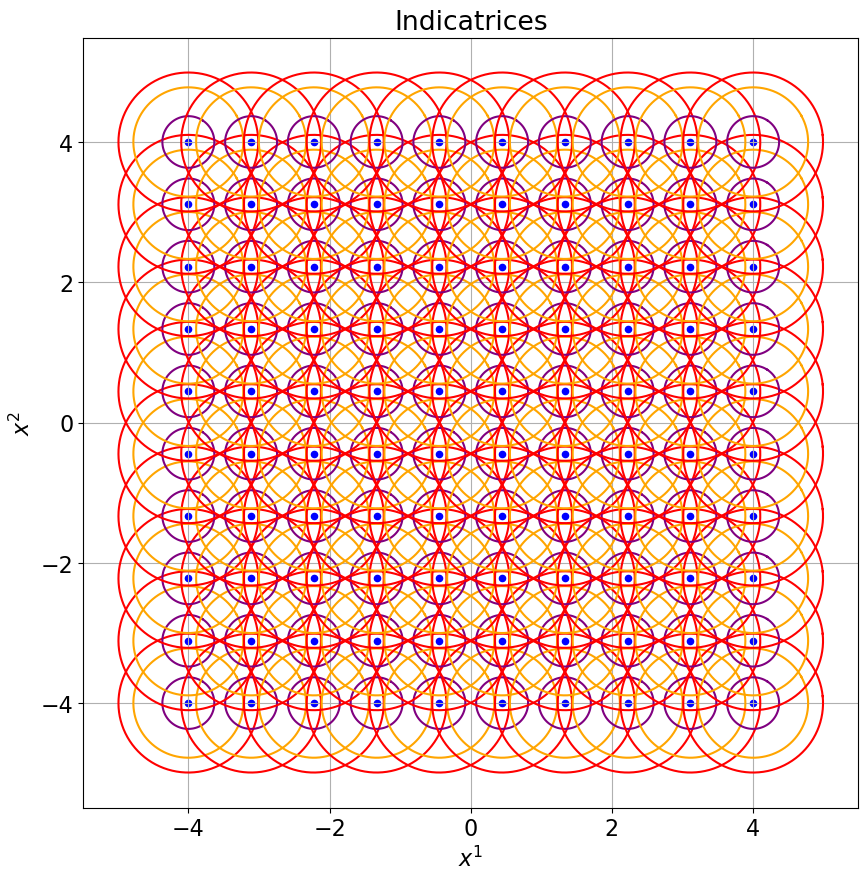

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[0,i,j,:], q2[0,i,j,:], color='red')
        ax.plot(q1[1,i,j,:], q2[1,i,j,:], color='orange')
        ax.plot(q1[2,i,j,:], q2[2,i,j,:], color='purple')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()

fig.savefig("Figures/Riemannian/t_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [19]:
N_spray = 50
x0 = jnp.zeros(2)
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.ones(N_spray)*0.5, jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda v: LM.IVPGeodesic(x0, v))(v)

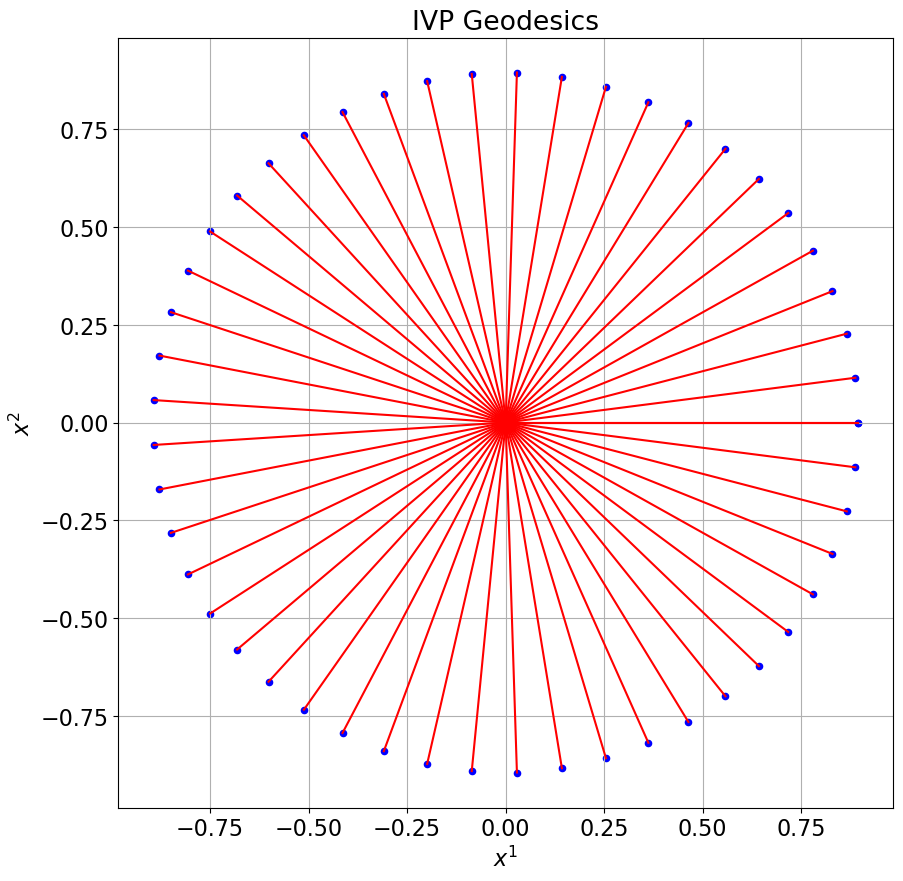

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/t_ivp2d.pdf", format="pdf", bbox_inches="tight")

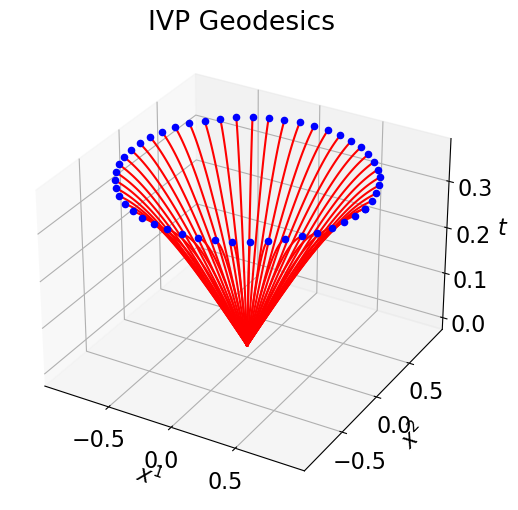

In [21]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('IVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/t_ivp3d.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [ ]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda xT: LM.BVPGeodesic(x0, xT))(xT)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/t_bvp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('BVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/t_bvp3d.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [ ]:
t = jnp.linspace(0.0,1.0,N_grid)
N_grid = 100
e1 = jnp.array([0.0,1.0, 0.0])
e2 = jnp.array([0.0,0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda t: vmap(lambda x: vmap(lambda y: LM.SectionalCurvature(t, y, e1, e2))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec[:,50,:]
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$t$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
fig.savefig("Figures/Riemannian/t_curvature.pdf", format="pdf", bbox_inches="tight")

## Time- and Position-Dependent Metric

### Defining the Metric

In [ ]:
a_fun = lambda t,x: jnp.exp(-((x[0])**2-t**2))
b_fun = lambda t,x: jnp.exp(-((x[1])**2-t**2))
theta_fun = lambda t,x: jnp.sum(x)+t

def G(t,x):
    
    theta = theta_fun(t,x)
    a2 = a_fun(t,x)**2
    b2 = b_fun(t,x)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
LM = LorentzianManifold(h=G, dim=2, GeodesicMethod="ODE")

### Indicatrix

In [ ]:
def indicatrix(t, x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(t,x)
    b = b_fun(t,x)
    theta = theta_fun(t,x)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [ ]:
t = jnp.array([0.1, 0.5, 1.0])
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [ ]:
q1, q2 = vmap(lambda t: vmap(lambda x: vmap(lambda y: indicatrix(t,y))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[0,i,j,:], q2[0,i,j,:], color='red')
        ax.plot(q1[1,i,j,:], q2[1,i,j,:], color='orange')
        ax.plot(q1[2,i,j,:], q2[2,i,j,:], color='purple')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()
fig.savefig("Figures/Riemannian/tp_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [ ]:
N_spray = 50
x0 = jnp.zeros(2)
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.ones(N_spray)*0.5, jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda v: LM.IVPGeodesic(x0, v))(v)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/tp_ivp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('IVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/tp_ivp3d.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [ ]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda xT: LM.BVPGeodesic(x0, xT))(xT)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("BVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/tp_bvp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('BVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/tp_bvp3d.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [ ]:
t = jnp.linspace(0.0,0.1,N_grid)
N_grid = 100
e1 = jnp.array([0.0,1.0, 0.0])
e2 = jnp.array([0.0,0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda t: vmap(lambda x: vmap(lambda y: LM.SectionalCurvature(t, y, e1, e2))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec[:,50,:]
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$t$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
fig.savefig("Figures/Riemannian/tp_curvature.pdf", format="pdf", bbox_inches="tight")

# Riemannian and Lorentzian Examples

In [1]:
#JAX
import jax.numpy as jnp
from jax import vmap

#Scipy
from scipy.ndimage.filters import gaussian_filter

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


#JaxMan
from JaxMan.manifold.riemannian.RiemannianManifold import RiemannianManifold
from JaxMan.manifold.lorentzian.LorentzianManifold import LorentzianManifold

/tmp/ipykernel_21854/3243853659.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
plt.rcParams.update({'font.size': 16})

## Position-Dependent Metric

### Defining the Metric

In [3]:
a_fun = lambda x: jnp.exp(-(x[0]**2))
b_fun = lambda x: jnp.exp(-(x[1]**2))
theta_fun = lambda x: jnp.sum(x)

def G(x):
    
    theta = theta_fun(x)
    a2 = a_fun(x)**2
    b2 = b_fun(x)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
RM = RiemannianManifold(G=G, dim=2, GeodesicMethod="ODE", ODEMethod = "euler", maxiter=10000, tol=1e-6)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Indicatrix

In [4]:
def indicatrix(x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(x)
    b = b_fun(x)
    theta = theta_fun(x)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [5]:
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [6]:
q1, q2 = vmap(lambda x: vmap(lambda y: indicatrix(y))(x))(X)

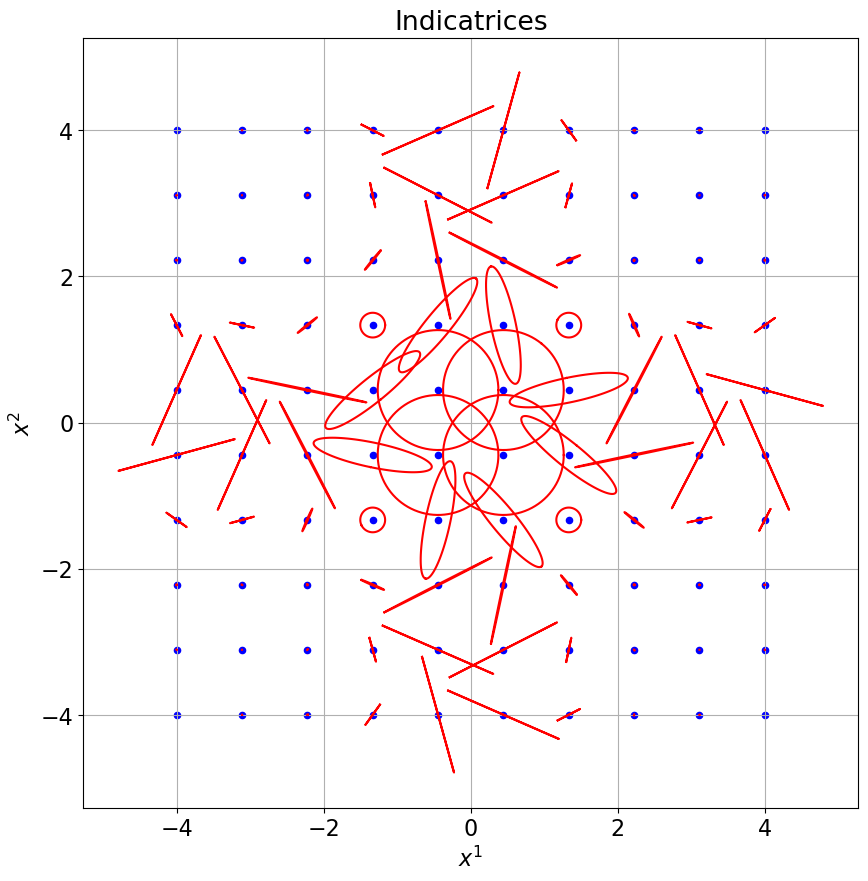

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[i,j,:], q2[i,j,:], color='red')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()
fig.savefig("Figures/Riemannian/p_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [8]:
N_spray = 50
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

t, gamma, dgamma = vmap(lambda v: RM.IVPGeodesic(x0, v))(v)

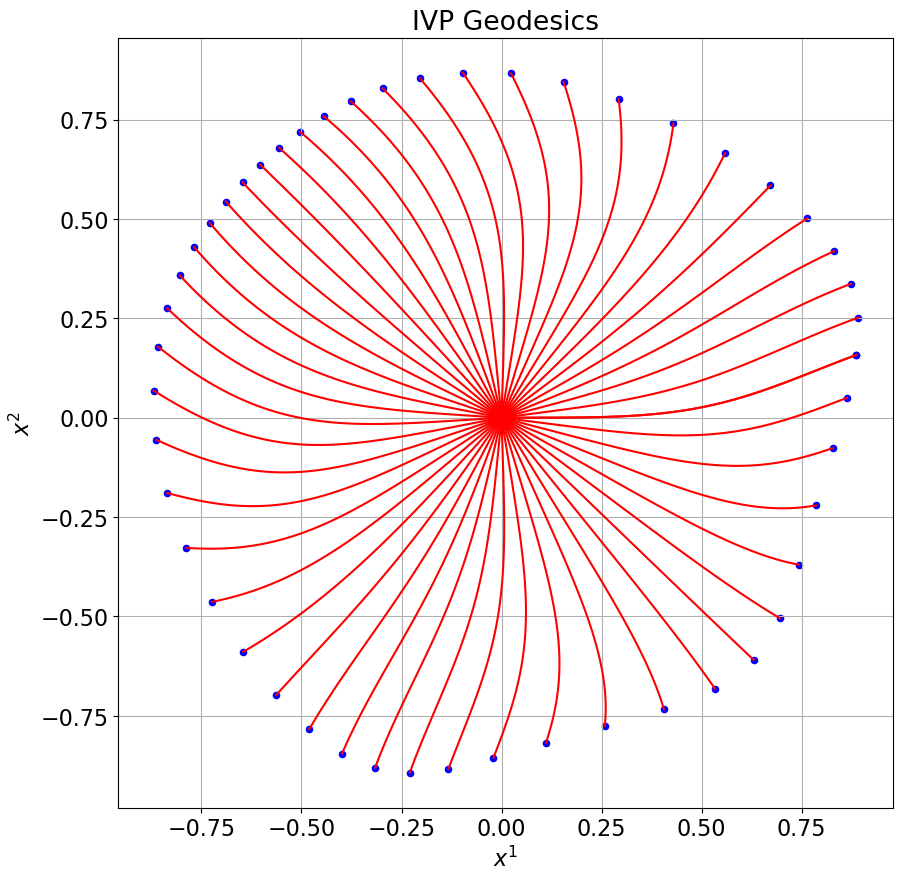

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.grid()
fig.savefig("Figures/Riemannian/p_ivp.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [10]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

t, gamma, dgamma = vmap(lambda xT: RM.BVPGeodesic(x0, xT))(xT)

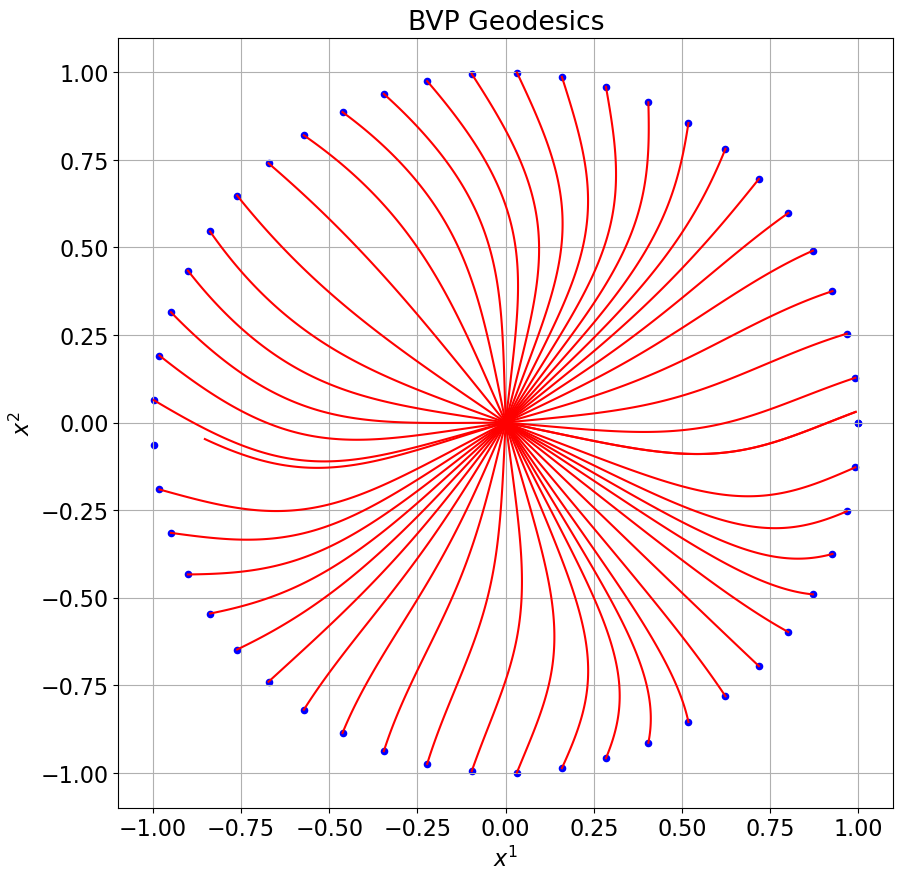

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("BVP Geodesics")
ax.scatter(xT[:,0], xT[:,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/p_bvp.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [12]:
N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda x: vmap(lambda y: RM.SectionalCurvature(y, e1, e2))(x))(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


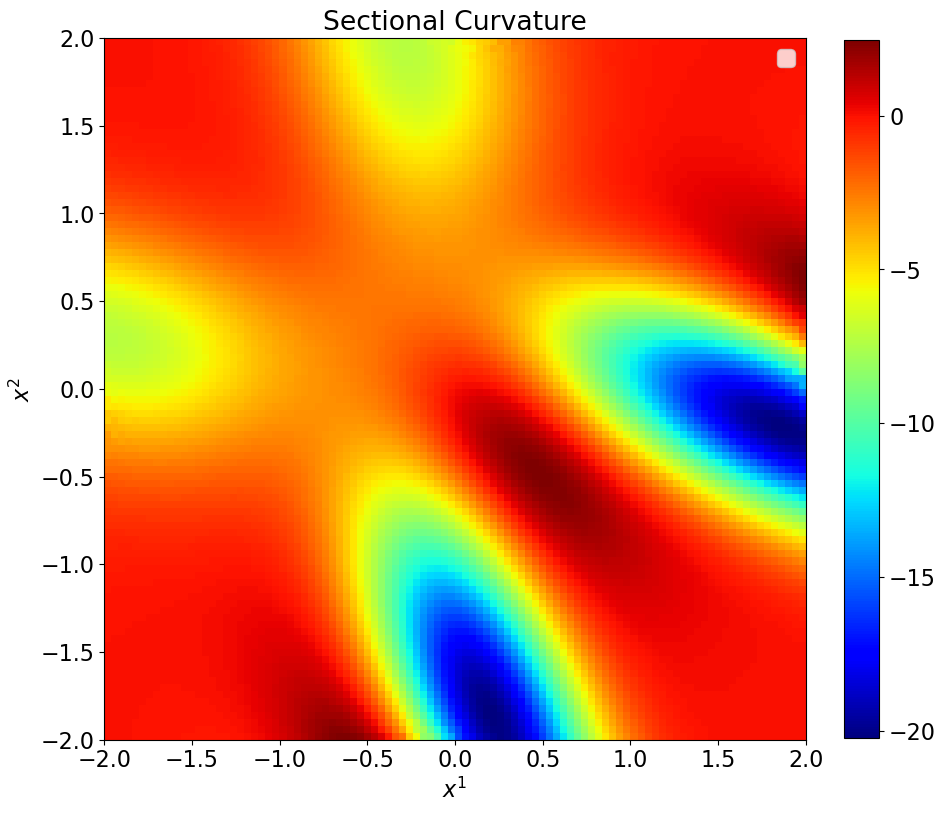

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

fig.savefig("Figures/Riemannian/p_curvature.pdf", format="pdf", bbox_inches="tight")

## Time-Dependent Metric

### Defining the Metric

In [14]:
a_fun = lambda t: jnp.exp(-(t**2))
b_fun = lambda t: jnp.exp(-(t**2))
theta_fun = lambda t: t

def G(t,x):
    
    theta = theta_fun(t)
    a2 = a_fun(t)**2
    b2 = b_fun(t)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
LM = LorentzianManifold(h=G, dim=2, GeodesicMethod="ODE")

### Indicatrix

In [15]:
def indicatrix(t, x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(t)
    b = b_fun(t)
    theta = theta_fun(t)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [16]:
t = jnp.array([0.1, 0.5, 1.0])
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [17]:
q1, q2 = vmap(lambda t: vmap(lambda x: vmap(lambda y: indicatrix(t,y))(x))(X))(t)

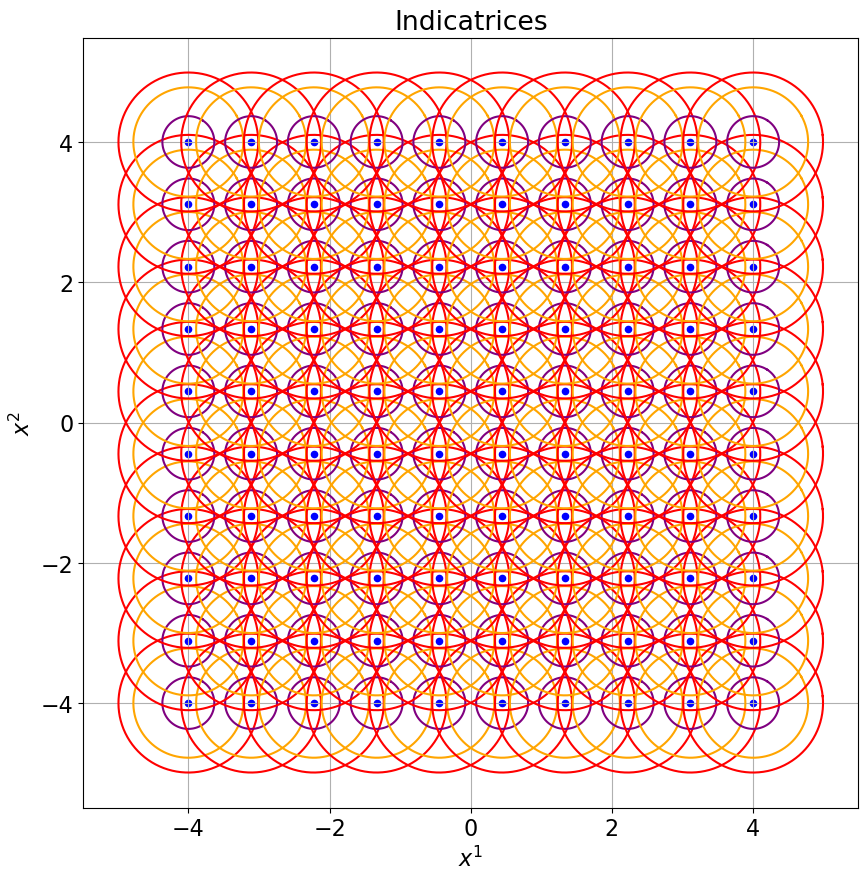

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[0,i,j,:], q2[0,i,j,:], color='red')
        ax.plot(q1[1,i,j,:], q2[1,i,j,:], color='orange')
        ax.plot(q1[2,i,j,:], q2[2,i,j,:], color='purple')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()

fig.savefig("Figures/Riemannian/t_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [19]:
N_spray = 50
x0 = jnp.zeros(2)
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.ones(N_spray)*0.5, jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda v: LM.IVPGeodesic(x0, v))(v)

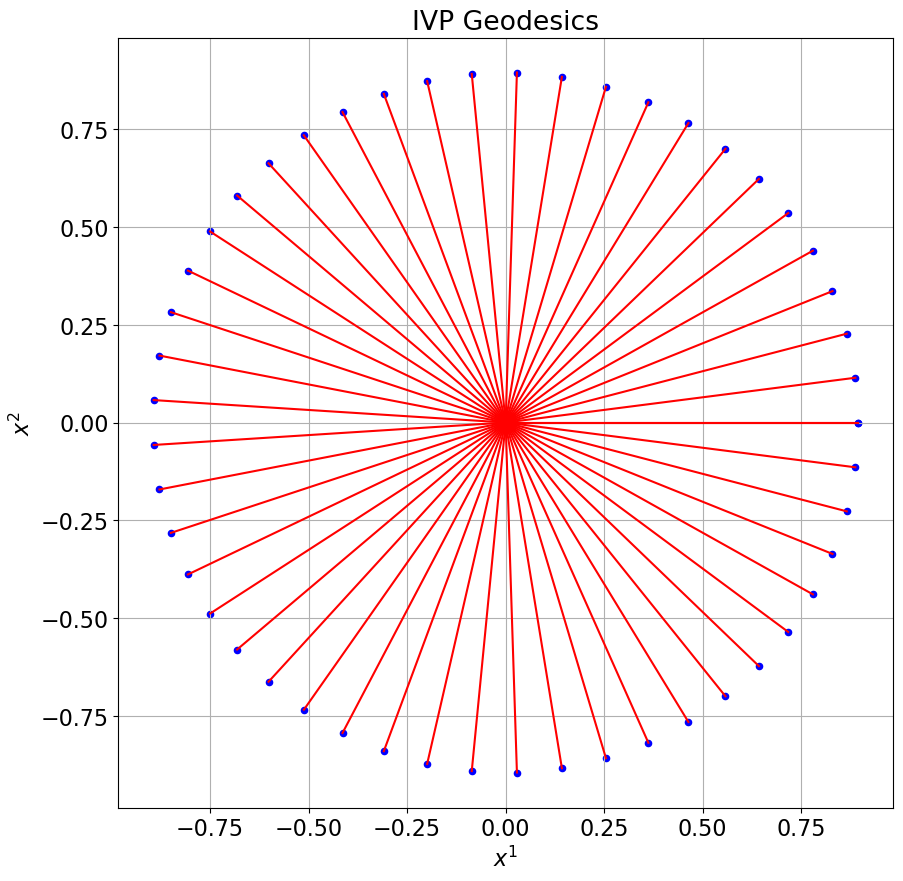

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/t_ivp2d.pdf", format="pdf", bbox_inches="tight")

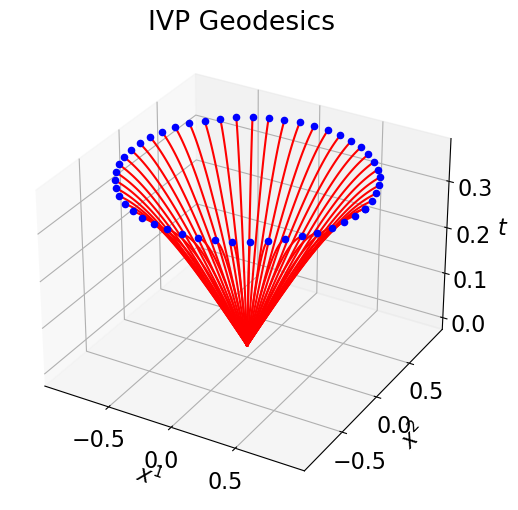

In [21]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('IVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/t_ivp3d.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [ ]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda xT: LM.BVPGeodesic(x0, xT))(xT)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/t_bvp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('BVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/t_bvp3d.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [ ]:
t = jnp.linspace(0.0,1.0,N_grid)
N_grid = 100
e1 = jnp.array([0.0,1.0, 0.0])
e2 = jnp.array([0.0,0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda t: vmap(lambda x: vmap(lambda y: LM.SectionalCurvature(t, y, e1, e2))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec[:,50,:]
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$t$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
fig.savefig("Figures/Riemannian/t_curvature.pdf", format="pdf", bbox_inches="tight")

## Time- and Position-Dependent Metric

### Defining the Metric

In [ ]:
a_fun = lambda t,x: jnp.exp(-((x[0])**2-t**2))
b_fun = lambda t,x: jnp.exp(-((x[1])**2-t**2))
theta_fun = lambda t,x: jnp.sum(x)+t

def G(t,x):
    
    theta = theta_fun(t,x)
    a2 = a_fun(t,x)**2
    b2 = b_fun(t,x)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
LM = LorentzianManifold(h=G, dim=2, GeodesicMethod="ODE")

### Indicatrix

In [ ]:
def indicatrix(t, x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(t,x)
    b = b_fun(t,x)
    theta = theta_fun(t,x)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [ ]:
t = jnp.array([0.1, 0.5, 1.0])
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [ ]:
q1, q2 = vmap(lambda t: vmap(lambda x: vmap(lambda y: indicatrix(t,y))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[0,i,j,:], q2[0,i,j,:], color='red')
        ax.plot(q1[1,i,j,:], q2[1,i,j,:], color='orange')
        ax.plot(q1[2,i,j,:], q2[2,i,j,:], color='purple')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()
fig.savefig("Figures/Riemannian/tp_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [ ]:
N_spray = 50
x0 = jnp.zeros(2)
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.ones(N_spray)*0.5, jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda v: LM.IVPGeodesic(x0, v))(v)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/tp_ivp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('IVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/tp_ivp3d.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [ ]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda xT: LM.BVPGeodesic(x0, xT))(xT)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("BVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
fig.savefig("Figures/Riemannian/tp_bvp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('BVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
fig.savefig("Figures/Riemannian/tp_bvp3d.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [ ]:
t = jnp.linspace(0.0,0.1,N_grid)
N_grid = 100
e1 = jnp.array([0.0,1.0, 0.0])
e2 = jnp.array([0.0,0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda t: vmap(lambda x: vmap(lambda y: LM.SectionalCurvature(t, y, e1, e2))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec[:,50,:]
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$t$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
fig.savefig("Figures/Riemannian/tp_curvature.pdf", format="pdf", bbox_inches="tight")

# Stochastic Pertubations

In [1]:
#JAX
import jax.numpy as jnp
from jax import vmap

#Scipy
from scipy.ndimage.filters import gaussian_filter

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl


#JaxMan
from JaxMan.manifold.riemannian.RiemannianManifold import RiemannianManifold
from JaxMan.manifold.lorentzian.LorentzianManifold import LorentzianManifold

/tmp/ipykernel_19435/3243853659.py:6: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [2]:
plt.rcParams.update({'font.size': 16})

## Position-Dependent Metric

In [3]:
mua_fun = lambda t,x: jnp.exp(-((x[0])**2-t**2))
mub_fun = lambda t,x: jnp.exp(-((x[1])**2-t**2))
mutheta_fun = lambda t,x: jnp.sum(x)+t

mua_fun = lambda t,x: jnp.exp(-((x[0])**2-t**2))
mub_fun = lambda t,x: jnp.exp(-((x[1])**2-t**2))
mutheta_fun = lambda t,x: jnp.sum(x)+t

### Defining the Metric

In [3]:
a_fun = lambda x: jnp.exp(-(x[0]**2))
b_fun = lambda x: jnp.exp(-(x[1]**2))
theta_fun = lambda x: jnp.sum(x)

def G(x):
    
    theta = theta_fun(x)
    a2 = a_fun(x)**2
    b2 = b_fun(x)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
RM = RiemannianManifold(G=G, dim=2, GeodesicMethod="ODE", ODEMethod = "euler", maxiter=10000, tol=1e-6)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Indicatrix

In [4]:
def indicatrix(x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(x)
    b = b_fun(x)
    theta = theta_fun(x)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [5]:
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [6]:
q1, q2 = vmap(lambda x: vmap(lambda y: indicatrix(y))(x))(X)

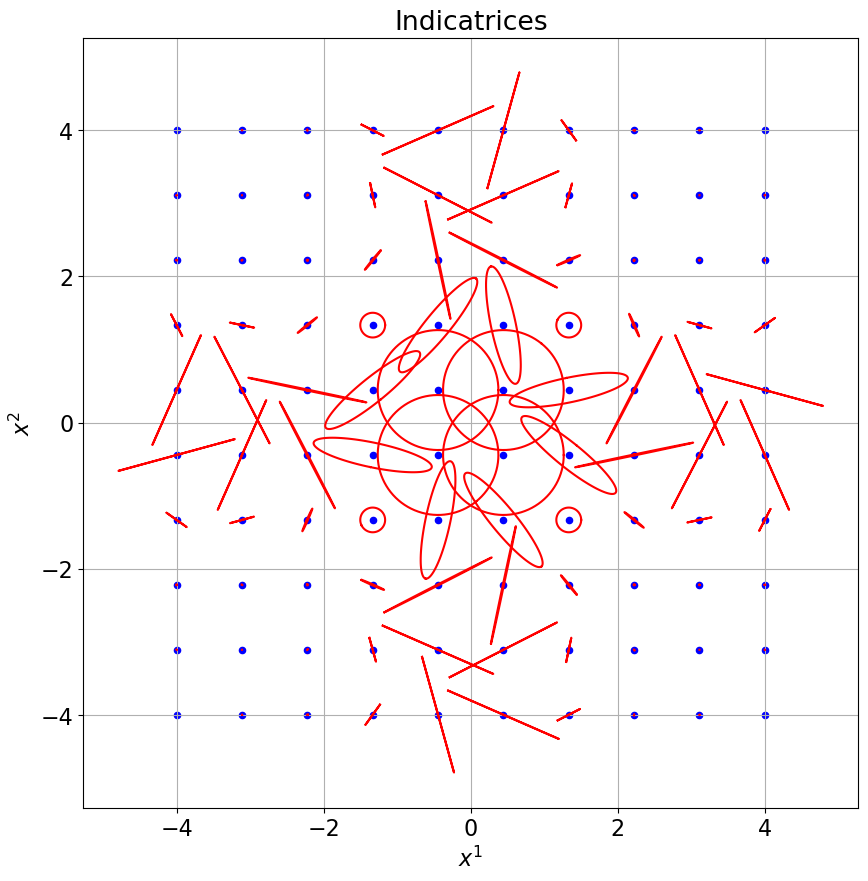

In [7]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[i,j,:], q2[i,j,:], color='red')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()
plt.savefig("Figures/Riemannian/p_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [8]:
N_spray = 50
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

t, gamma, dgamma = vmap(lambda v: RM.IVPGeodesic(x0, v))(v)

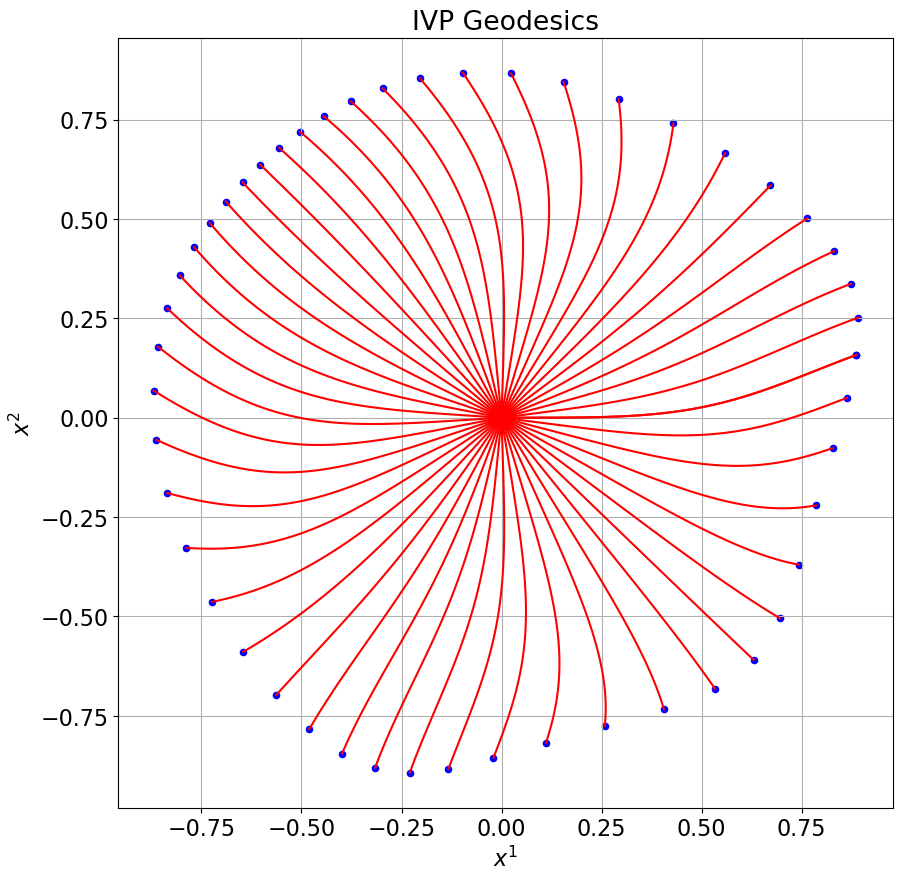

In [9]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.grid()
plt.savefig("Figures/Riemannian/p_ivp.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [10]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

t, gamma, dgamma = vmap(lambda xT: RM.BVPGeodesic(x0, xT))(xT)

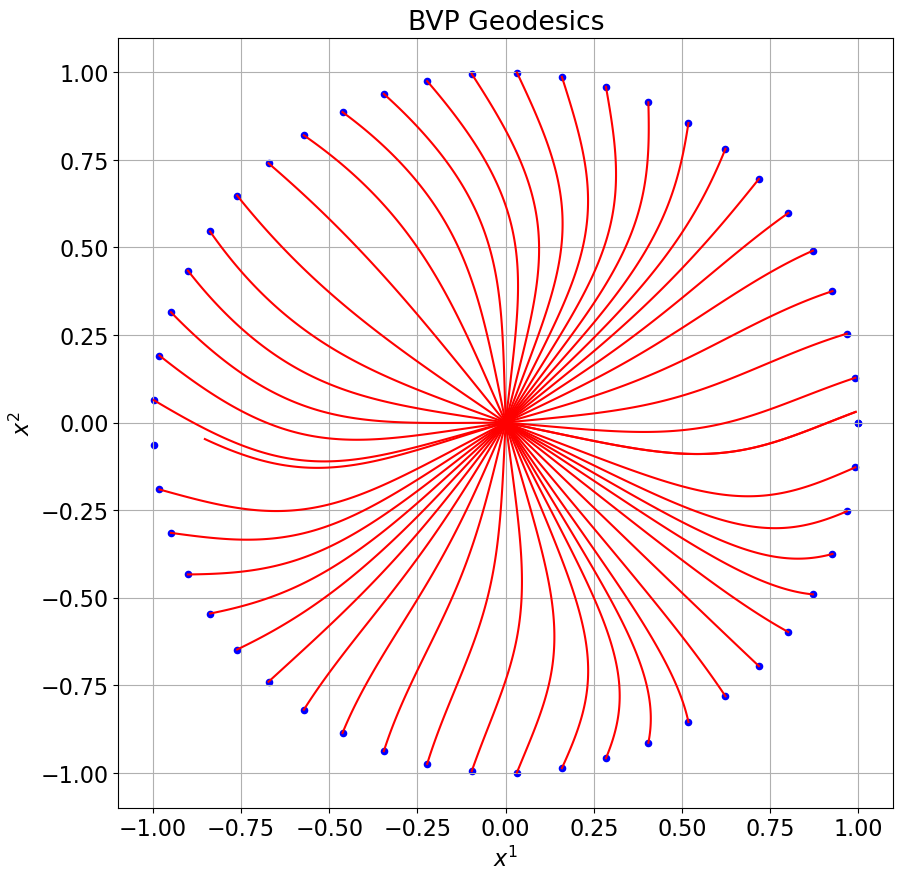

In [11]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("BVP Geodesics")
ax.scatter(xT[:,0], xT[:,1], color='blue', s=20)
ax.grid()
plt.savefig("Figures/Riemannian/p_bvp.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [12]:
N_grid = 100
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda x: vmap(lambda y: RM.SectionalCurvature(y, e1, e2))(x))(X)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


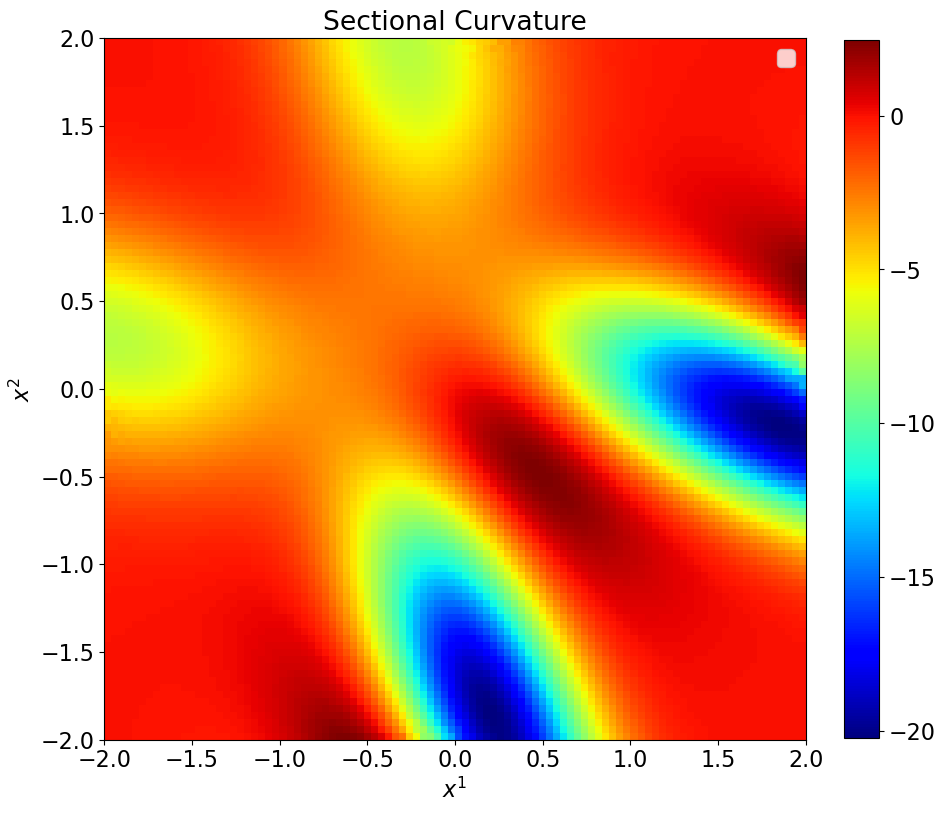

<Figure size 640x480 with 0 Axes>

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([-2.0, 2.0])
ax.set_ylim([-2.0, 2.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()

plt.savefig("Figures/Riemannian/p_curvature.pdf", format="pdf", bbox_inches="tight")

## Time-Dependent Metric

### Defining the Metric

In [14]:
a_fun = lambda t: jnp.exp(-(t**2))
b_fun = lambda t: jnp.exp(-(t**2))
theta_fun = lambda t: t

def G(t,x):
    
    theta = theta_fun(t)
    a2 = a_fun(t)**2
    b2 = b_fun(t)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
LM = LorentzianManifold(h=G, dim=2, GeodesicMethod="ODE")

### Indicatrix

In [15]:
def indicatrix(t, x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(t)
    b = b_fun(t)
    theta = theta_fun(t)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [16]:
t = jnp.array([0.1, 0.5, 1.0])
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [17]:
q1, q2 = vmap(lambda t: vmap(lambda x: vmap(lambda y: indicatrix(t,y))(x))(X))(t)

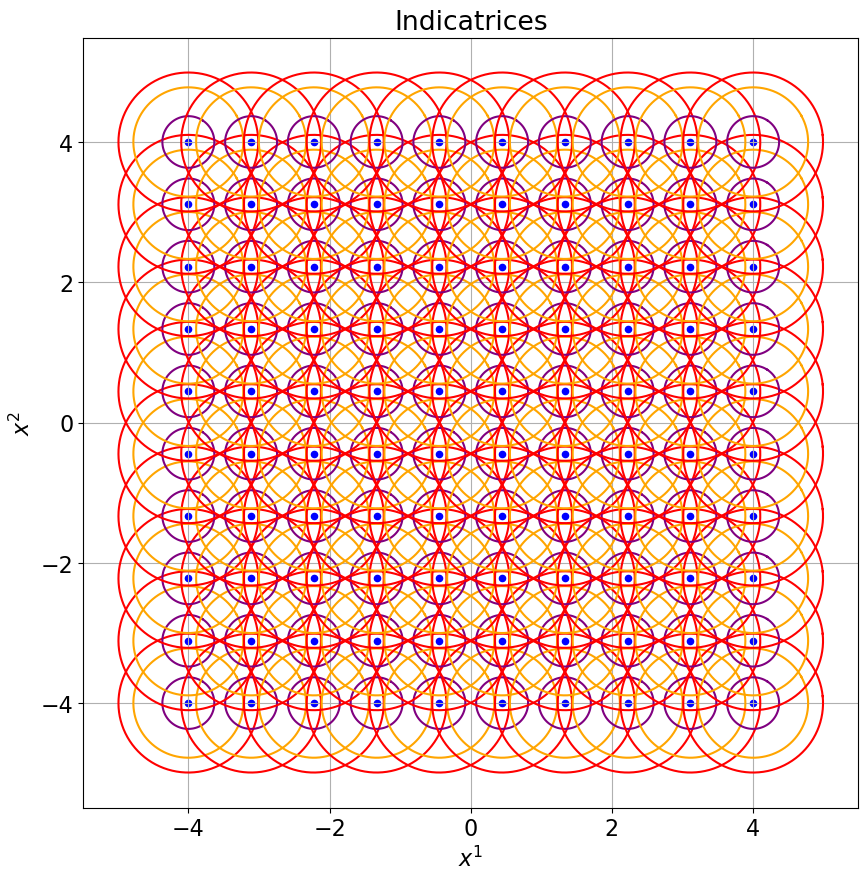

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[0,i,j,:], q2[0,i,j,:], color='red')
        ax.plot(q1[1,i,j,:], q2[1,i,j,:], color='orange')
        ax.plot(q1[2,i,j,:], q2[2,i,j,:], color='purple')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()

plt.savefig("Figures/Riemannian/t_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [19]:
N_spray = 50
x0 = jnp.zeros(2)
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.ones(N_spray)*0.5, jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda v: LM.IVPGeodesic(x0, v))(v)

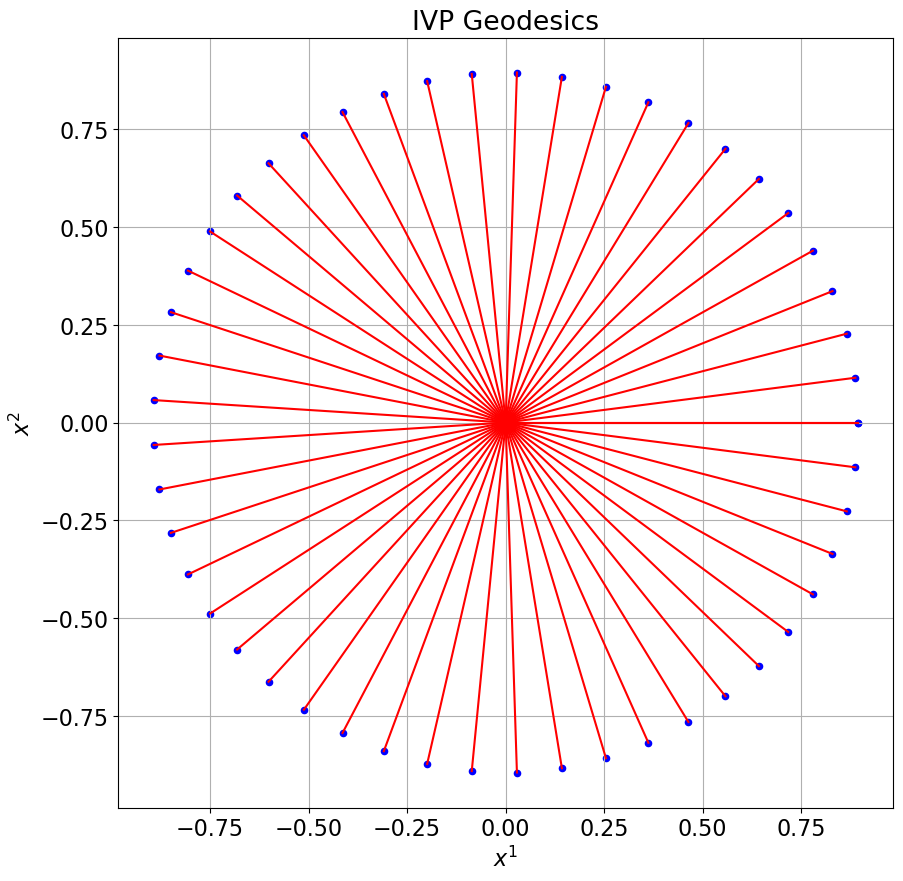

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
plt.savefig("Figures/Riemannian/t_ivp2d.pdf", format="pdf", bbox_inches="tight")

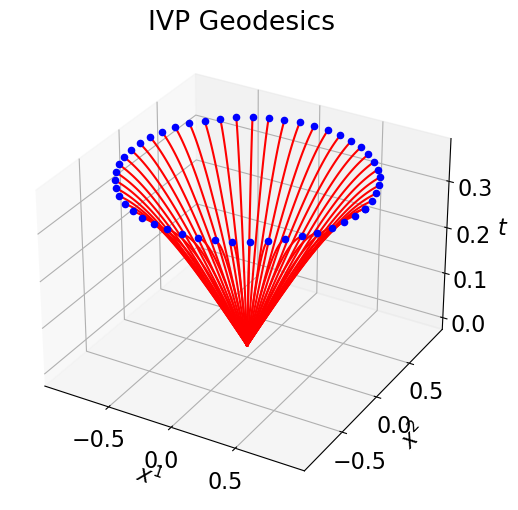

<Figure size 640x480 with 0 Axes>

In [21]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('IVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
plt.savefig("Figures/Riemannian/t_ivp3d.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [ ]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda xT: LM.BVPGeodesic(x0, xT))(xT)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
plt.savefig("Figures/Riemannian/t_bvp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('BVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
plt.savefig("Figures/Riemannian/t_bvp3d.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [ ]:
t = jnp.linspace(0.0,1.0,N_grid)
N_grid = 100
e1 = jnp.array([0.0,1.0, 0.0])
e2 = jnp.array([0.0,0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda t: vmap(lambda x: vmap(lambda y: LM.SectionalCurvature(t, y, e1, e2))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec[:,50,:]
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$t$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
plt.savefig("Figures/Riemannian/t_curvature.pdf", format="pdf", bbox_inches="tight")

## Time- and Position-Dependent Metric

### Defining the Metric

In [ ]:
a_fun = lambda t,x: jnp.exp(-((x[0])**2-t**2))
b_fun = lambda t,x: jnp.exp(-((x[1])**2-t**2))
theta_fun = lambda t,x: jnp.sum(x)+t

def G(t,x):
    
    theta = theta_fun(t,x)
    a2 = a_fun(t,x)**2
    b2 = b_fun(t,x)**2
    costheta = jnp.cos(theta)
    sintheta = jnp.sin(theta)
    
    return jnp.array([[a2*sintheta**2+b2*costheta**2, (a2-b2)*costheta*sintheta],
                     [(a2-b2)*costheta*sintheta, a2*costheta**2+b2*sintheta**2]])/(a2*b2)

#simple test for paraboloid
#def G(x):
#    
#    x1 = x[0]
#    x2 = x[1]
#    
#    return jnp.array([[1+4*(x1**2), 4*x1*x2],
#                     [4*x1*x2, 1+4*(x2**2)]])
    
LM = LorentzianManifold(h=G, dim=2, GeodesicMethod="ODE")

### Indicatrix

In [ ]:
def indicatrix(t, x, N=100):
    
    phi = jnp.linspace(0, 2*jnp.pi, N)
    
    a = a_fun(t,x)
    b = b_fun(t,x)
    theta = theta_fun(t,x)
    
    x1 = a*jnp.cos(phi)*jnp.cos(theta)-b*jnp.sin(phi)*jnp.sin(theta)+x[0]
    x2 = a*jnp.cos(phi)*jnp.sin(theta)+b*jnp.sin(phi)*jnp.cos(theta)+x[1]
    
    return x1, x2

In [ ]:
t = jnp.array([0.1, 0.5, 1.0])
N_grid = 10
e1 = jnp.array([1.0, 0.0])
e2 = jnp.array([0.0, 1.0])
x1 = jnp.linspace(-4.0, 4.0, N_grid)
x2 = jnp.linspace(-4.0, 4.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)

In [ ]:
q1, q2 = vmap(lambda t: vmap(lambda x: vmap(lambda y: indicatrix(t,y))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(N_grid):
    for j in range(N_grid):
        ax.plot(q1[0,i,j,:], q2[0,i,j,:], color='red')
        ax.plot(q1[1,i,j,:], q2[1,i,j,:], color='orange')
        ax.plot(q1[2,i,j,:], q2[2,i,j,:], color='purple')
        ax.scatter(X[i,j,0], X[i,j,1], color='blue', s=20)
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("Indicatrices")
ax.grid()
plt.savefig("Figures/Riemannian/tp_indicatrix.pdf", format="pdf", bbox_inches="tight")

### IVP Geodesics 

In [ ]:
N_spray = 50
x0 = jnp.zeros(2)
dt = 0.5
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
v = jnp.array([jnp.ones(N_spray)*0.5, jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda v: LM.IVPGeodesic(x0, v))(v)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("IVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
plt.savefig("Figures/Riemannian/tp_ivp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('IVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
plt.savefig("Figures/Riemannian/tp_ivp3d.pdf", format="pdf", bbox_inches="tight")

### BVP Geodesics 

In [ ]:
x0 = jnp.zeros(2)
phi = jnp.linspace(0, 2*jnp.pi,N_spray)
xT=jnp.array([jnp.cos(phi), jnp.sin(phi)]).T

grid, t, gamma, dgamma = vmap(lambda xT: LM.BVPGeodesic(x0, xT))(xT)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(gamma[:,:,0].T, gamma[:,:,1].T, color='red')
ax.set_xlabel("$x^{1}$")
ax.set_ylabel("$x^{2}$")
ax.set_title("BVP Geodesics")
ax.scatter(gamma[:,-1,0], gamma[:,-1,1], color='blue', s=20)
ax.grid()
plt.savefig("Figures/Riemannian/tp_bvp2d.pdf", format="pdf", bbox_inches="tight")

In [ ]:
#fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111)
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, alpha=0.2)
for i in range(len(v)):
    ax.plot(gamma[i,:,0], gamma[i,:,1], t[i], color='red')
    ax.scatter(gamma[i,-1,0], gamma[i,-1,1], t[i, -1], color='blue')
#ax.axis('off')
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.set_zlabel(r'$t$')
ax.set_title('BVP Geodesics')
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])
plt.show()
plt.savefig("Figures/Riemannian/tp_bvp3d.pdf", format="pdf", bbox_inches="tight")

### Sectional Curvature

In [ ]:
t = jnp.linspace(0.0,0.1,N_grid)
N_grid = 100
e1 = jnp.array([0.0,1.0, 0.0])
e2 = jnp.array([0.0,0.0, 1.0])
x1 = jnp.linspace(-2.0, 2.0, N_grid)
x2 = jnp.linspace(-2.0, 2.0, N_grid)
X1, X2 = jnp.meshgrid(x1,x2)
X = jnp.concatenate((X1.reshape(N_grid, N_grid, 1), X2.reshape(N_grid, N_grid, 1)), axis=-1)
sec = vmap(lambda t: vmap(lambda x: vmap(lambda y: LM.SectionalCurvature(t, y, e1, e2))(x))(X))(t)

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#heatmap, xedges, yedges = np.histogram2d(spherical_data[:,0], spherical_data[:,1], bins=bins)
#heatmap = gaussian_filter(sec, sigma=1.0)
#heatmap /= jnp.linalg.norm(heatmap)
heatmap = sec[:,50,:]
extent = [-2.0, 2.0, -2.0, 2.0]
ax.imshow(heatmap.T, extent=extent, origin='lower', cmap=cm.jet)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_title("Sectional Curvature")
ax.set_xlabel("$t$")
ax.set_ylabel("$x^{2}$")
ax.legend()
m = mpl.cm.ScalarMappable(cmap=mpl.cm.jet)
m.set_array(heatmap)
fig.colorbar(m, ax=ax, fraction=0.045, pad=0.05)

plt.show()
plt.savefig("Figures/Riemannian/tp_curvature.pdf", format="pdf", bbox_inches="tight")